<a href="https://colab.research.google.com/github/jgk-1979/NLP/blob/main/Project12_NLP_SarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Part TWO 


*   Social media analytics




• CONTEXT: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

• DATA DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com.
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

• PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters
to determine the customer sentiments.
Steps and tasks:
1. Read and explore the data
2. Retain relevant columns
3. Get length of each sentence
4. Define parameters
5. Get indices for words
6. Create features and labels
7. Get vocabulary size
8. Create a weight matrix using GloVe embeddings
9. Define and compile a Bidirectional LSTM model.
Hint: Be analytical and experimental here in trying new approaches to design the best model.
10. Fit the model and check the validation accuracy

###Import Libraries

In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import plotly.graph_objs as go
import random
import re
import string
import time
import sklearn
import sklearn.metrics  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional, SimpleRNN, Activation, Input
from keras.initializers import Constant
import keras.metrics as metrics
from keras.utils.np_utils import to_categorical

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [ ]:

start_of_run = time.perf_counter()

###Read and Explore the data

#### Read the json file

In [ ]:
data_file_SHDv2='/content/drive/MyDrive/Colab Notebooks/11_NLP/Project 12/Data/Sarcasm_Headlines_Dataset_v2.json'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import json

def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data_from_json = list(parse_data(data_file_SHDv2))

In [ ]:
data_file=pd.DataFrame(data_from_json)

In [ ]:
data_file = data_file[['headline','is_sarcastic']]
data_file.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


#### Explore the data

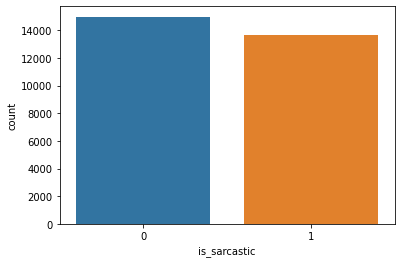

In [ ]:
ax = sns.countplot(x="is_sarcastic", data=data_file)

In [ ]:
data_file['headline'] = data_file['headline'].apply(lambda x: x.lower())
data_file['headline'] = data_file['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
headlines = data_file


In [ ]:
data_file.last

<bound method NDFrame.last of                                                 headline  is_sarcastic
0      thirtysomething scientists unveil doomsday clo...             1
1      dem rep totally nails why congress is falling ...             0
2       eat your veggies 9 deliciously different recipes             0
3      inclement weather prevents liar from getting t...             1
4      mother comes pretty close to using word stream...             1
...                                                  ...           ...
28614       jews to celebrate rosh hashasha or something             1
28615  internal affairs investigator disappointed con...             1
28616  the most beautiful acceptance speech this week...             0
28617  mars probe destroyed by orbiting spielberggate...             1
28618                 dad clarifies this not a food stop             1

[28619 rows x 2 columns]>

In [ ]:
headlines.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
headlines['words'] = headlines['headline'].str.count(' ') + 1


In [ ]:
headlines.describe()

,is_sarcastic,words
count,28619.000000,28619.000000
mean,0.476397,10.051854
std,0.499451,3.390939
min,0.000000,2.000000
25%,0.000000,8.000000
50%,0.000000,10.000000
75%,1.000000,12.000000
max,1.000000,151.000000


In [ ]:
headlines.describe(include='object')

,headline
count,28619
unique,28502
top,no way to prevent this says only nation where ...
freq,12


In [ ]:
data_file.describe(include='object')

,headline
count,28619
unique,28502
top,no way to prevent this says only nation where ...
freq,12


In [ ]:
headlines.count()

headline        28619
is_sarcastic    28619
words           28619
dtype: int64

In [ ]:
len(headlines[headlines.headline.duplicated()])

117

The dataset had duplicated headlines. I wonder if these duplicated headlines are classified differently or not.

In [ ]:
count_of_target = 0
for target in headlines.groupby(headlines.headline).is_sarcastic.agg(list):
    if(len(set(list(target))) != 1):
        count_of_target += 1
print(count_of_target)

0


It is important to consider this as if there are different labels for the same headline, it will confuse the model while training. Fortunately, although there are duplicate headlines in the dataset, they are not labelled differently.

In [ ]:
headlines.drop_duplicates(keep="first",inplace=True)


In [ ]:
headlines.count()

headline        28502
is_sarcastic    28502
words           28502
dtype: int64

In [ ]:
headlines.describe()

,is_sarcastic,words
count,28502.000000,28502.000000
mean,0.475440,10.062803
std,0.499405,3.387967
min,0.000000,2.000000
25%,0.000000,8.000000
50%,0.000000,10.000000
75%,1.000000,12.000000
max,1.000000,151.000000


In [ ]:
headlines=headlines.drop(['words'],axis=1)

In [ ]:
headlines.count()

headline        28502
is_sarcastic    28502
dtype: int64

In [ ]:
headlines.describe()

,is_sarcastic
count,28502.000000
mean,0.475440
std,0.499405
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


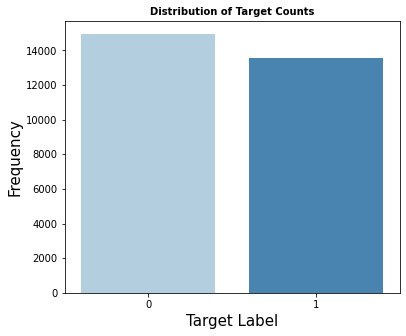

In [ ]:
plt.figure(figsize=(6,5))
sns.countplot(headlines.is_sarcastic, palette='Blues')
plt.title("Distribution of Target Counts", size=10, weight='bold')
plt.xlabel("Target Label", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

As displayed, there is an imbalance towards the positive class (sarcastic) in our dataset. This is important as it can have significant effect on the classifier although the imbalance is not severe hence we will not perform any oversampling and undersampling techniques to tweak this but it still worthy of note-taking.

####Display the Word Cloud for the sentences that are Sarcastic and those that are not Sarcastic

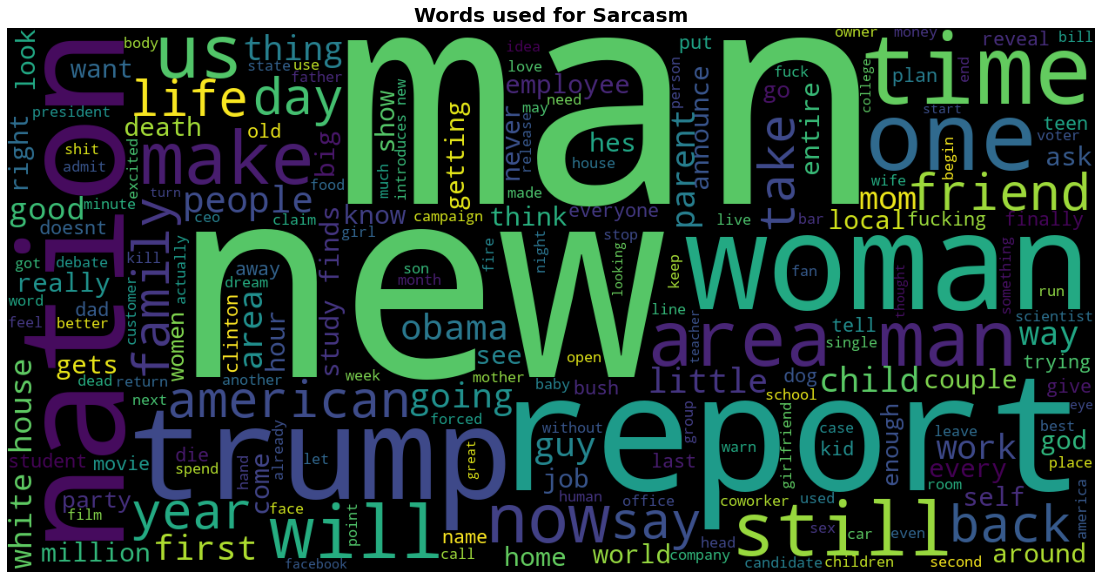

In [ ]:
all_keywords = " ".join(line for line in headlines[headlines.is_sarcastic==1].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

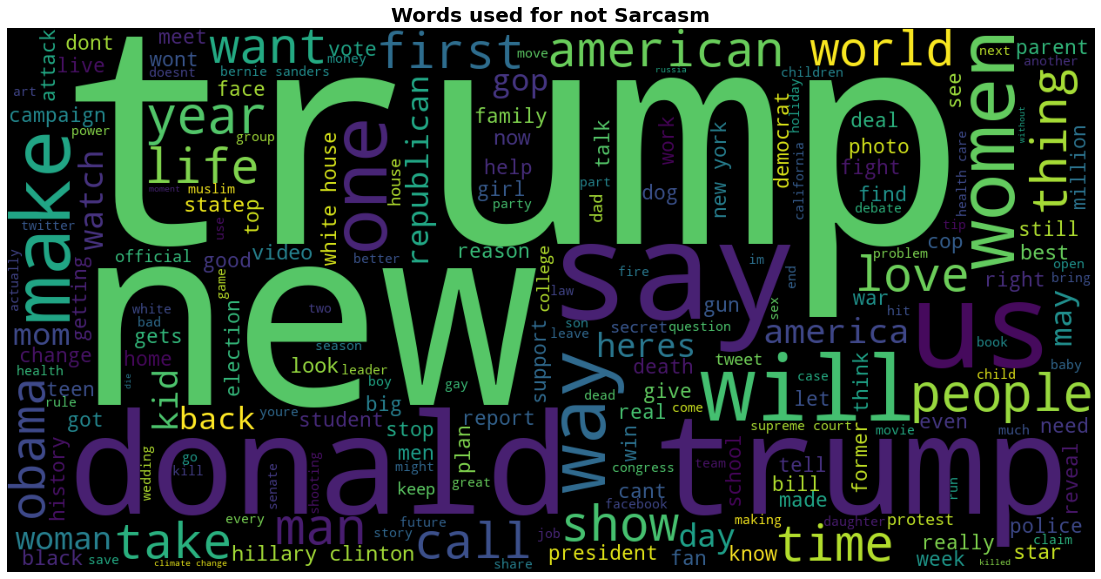

In [ ]:
all_keywords = " ".join(line for line in headlines[headlines.is_sarcastic==0].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for not Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

####Get length of each sentence

Number of characters in texts



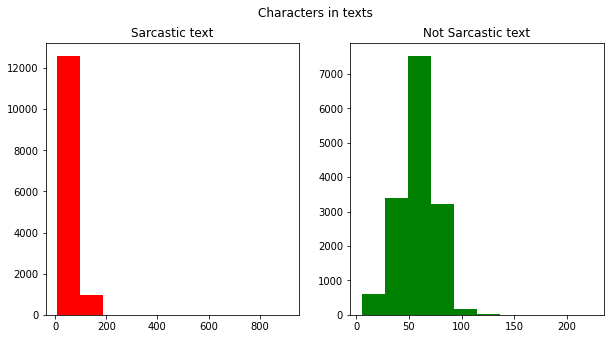

In [ ]:
df=headlines

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

Number of words in each text



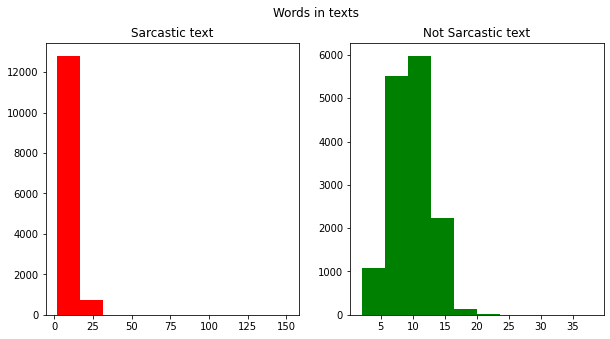

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')

fig.suptitle('Words in texts')
plt.show()

Average word length in a text



Text(0.5, 0.98, 'Average word length in each text under Sarcastic versus Non-Sarvastic')

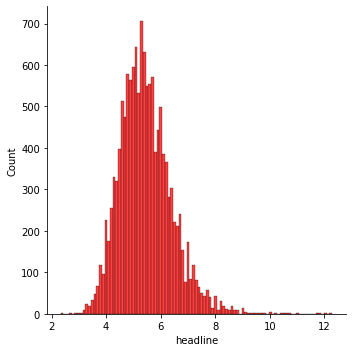

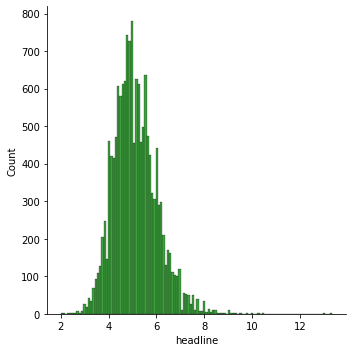

In [ ]:
warnings.filterwarnings('ignore')

word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])

sns.displot(word.map(lambda x: np.mean(x)),color='red')

word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.displot(word.map(lambda x: np.mean(x)),color='green')

fig.suptitle('Average word length in each text under Sarcastic versus Non-Sarvastic')

In [ ]:
import nltk
nltk.download('stopwords')

def clean_headline(headline):
    STOPWORDS = set(stopwords.words("english"))
    headline = headline.lower()
    headline = " ".join(word for word in headline.split() if word not in STOPWORDS)
    headline = "".join(word for word in headline if word not in set(string.punctuation))
    return headline

headlines.headline = headlines.headline.apply(clean_headline)
headlines.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails congress falling short g...,0
2,eat veggies 9 deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word streaming...,1


####Build Corpus and get Vocabulary Size

In [ ]:
import nltk
nltk.download('punkt')

corpus = []
for text in headlines['headline']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)
num_words = len(corpus)
print(num_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
28502


###Create features and labels

In [ ]:
X = headlines['headline'].values
y = headlines['is_sarcastic'].values
X_train, X_test_Orig, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=18)

In [ ]:
del [[df,X,y]]
import gc
gc.collect()


9201

In [ ]:
max_len = 100
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')

X_test = tokenizer.texts_to_sequences(X_test_Orig)
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')


In [ ]:
word_index = tokenizer.word_index
print("Number of unique words: {}".format(len(word_index)))

Number of unique words: 26478


###Create a weight matrix using GloVe embedding

In [ ]:
embedding = {}
glove_twitter_27B_100d_file = '/content/drive/MyDrive/Colab Notebooks/11_NLP/Project 12/Data/glove.twitter.27B.100d.txt'
# glove_twitter_27B_200d_file = '/content/drive/MyDrive/Colab Notebooks/11_NLP/Project 12/Data/glove.twitter.27B.200d.txt'

glove_twitter_27B_file = glove_twitter_27B_100d_file
# if (max_len == 200):
#   glove_twitter_27B_file = glove_twitter_27B_200d_file 

with open(glove_twitter_27B_file) as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

In [ ]:
embedding_matrix = np.zeros((num_words, max_len))
for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [ ]:
embedding_matrix.shape

(28502, 100)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(22801, 100) (22801,)
(5701, 100) (5701,)


### Build different models for exploratory purpose along with the Bidirectional LSTM

####Simple RNN model- Build and Priduct - for exploratory purpose

In [ ]:
simpleRNN = model = Sequential()

simpleRNN.add(Embedding(input_dim=num_words, output_dim=max_len, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
simpleRNN.add(SimpleRNN(64, dropout=0.1))
simpleRNN.add(Dense(1, activation='sigmoid'))

simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2850200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,860,825
Trainable params: 10,625
Non-trainable params: 2,850,200
_________________________________________________________________


In [ ]:
simpleRNN_history = simpleRNN.fit(X_train, y_train, epochs=4, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/4
23/23 [==============================] - 7s 124ms/step - loss: 0.6584 - accuracy: 0.6040 - val_loss: 0.6374 - val_accuracy: 0.6460
Epoch 2/4
23/23 [==============================] - 2s 108ms/step - loss: 0.6070 - accuracy: 0.6748 - val_loss: 0.5812 - val_accuracy: 0.7018
Epoch 3/4
23/23 [==============================] - 3s 110ms/step - loss: 0.5809 - accuracy: 0.7018 - val_loss: 0.5622 - val_accuracy: 0.7148
Epoch 4/4
23/23 [==============================] - 3s 110ms/step - loss: 0.5641 - accuracy: 0.7151 - val_loss: 0.5473 - val_accuracy: 0.7279


In [ ]:
#Presentation of accuracy and loss
def show_acc_loss_chart(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, len(val_acc)+1)
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='center right')
  plt.xlim(1, len(val_acc)+1)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='center right')
  plt.xlim(1, len(val_acc)+1)
  plt.title('Training and Validation Loss')
  plt.show()

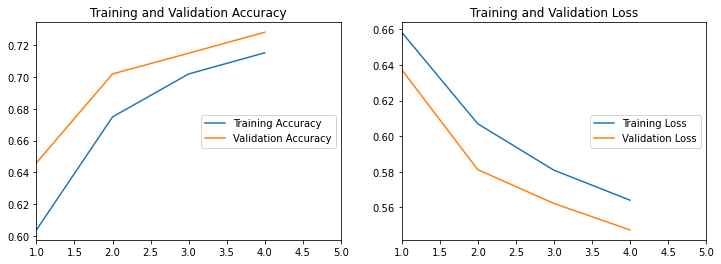

In [ ]:
#Presentation of accuracy and loss
show_acc_loss_chart(simpleRNN_history)

In [ ]:
predicted_val = simpleRNN.predict(X_test)

In [ ]:
predicted_val[predicted_val <= 0.5] = int(0)
predicted_val[predicted_val > 0.5] = int(1)
predicted_simpleRNN = predicted_val[:,0]

In [ ]:
print(classification_report(y_test, predicted_simpleRNN,target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.76      0.70      0.73      2985
    Sarcastic       0.70      0.76      0.73      2716

     accuracy                           0.73      5701
    macro avg       0.73      0.73      0.73      5701
 weighted avg       0.73      0.73      0.73      5701



####Building a CNN model for exploratory purpose

In [ ]:
#CNN Model


CNN_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, max_len, input_length = max_len),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
CNN_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          2850200   
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            32064     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,883,849
Trainable params: 2,883,849
Non-trainable params: 0
____________________________________________

In [ ]:
CNN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
CNN_history = CNN_model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), verbose=1)


Epoch 1/4
713/713 [==============================] - 12s 6ms/step - loss: 0.5486 - accuracy: 0.7079 - val_loss: 0.4331 - val_accuracy: 0.7972
Epoch 2/4
713/713 [==============================] - 4s 5ms/step - loss: 0.2797 - accuracy: 0.8840 - val_loss: 0.4190 - val_accuracy: 0.8125
Epoch 3/4
713/713 [==============================] - 4s 6ms/step - loss: 0.1442 - accuracy: 0.9487 - val_loss: 0.4954 - val_accuracy: 0.8074
Epoch 4/4
713/713 [==============================] - 4s 6ms/step - loss: 0.0696 - accuracy: 0.9767 - val_loss: 0.6296 - val_accuracy: 0.8041


In [ ]:
np.max(CNN_history.history['val_accuracy'])

0.8124890327453613

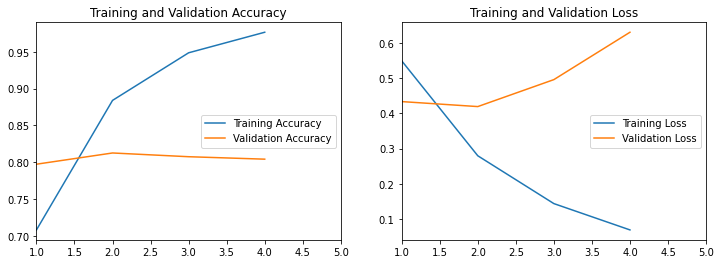

In [ ]:
#Presentation of accuracy and loss
show_acc_loss_chart(CNN_history)

####Building a simple forward LSTM model for exploratory purpose

In [ ]:
fwd_lstm_model = Sequential()

fwd_lstm_model.add(Embedding(input_dim=num_words, output_dim=max_len, embeddings_initializer=Constant(embedding_matrix),input_length=max_len, trainable=False))
fwd_lstm_model.add(LSTM(64, dropout=0.3))
# fwd_lstm_model.add(Dense(32, activation='tanh'))
fwd_lstm_model.add(Dense(16, activation='relu'))
fwd_lstm_model.add(Dense(1, activation='sigmoid'))

fwd_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fwd_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2850200   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,893,497
Trainable params: 43,297
Non-trainable params: 2,850,200
_________________________________________________________________


In [ ]:
fwd_lstm_history = fwd_lstm_model.fit(X_train, y_train, epochs=4, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/4
23/23 [==============================] - 4s 45ms/step - loss: 0.6923 - accuracy: 0.5248 - val_loss: 0.6920 - val_accuracy: 0.5236
Epoch 2/4
23/23 [==============================] - 0s 20ms/step - loss: 0.6919 - accuracy: 0.5248 - val_loss: 0.6920 - val_accuracy: 0.5236
Epoch 3/4
23/23 [==============================] - 0s 20ms/step - loss: 0.6920 - accuracy: 0.5248 - val_loss: 0.6920 - val_accuracy: 0.5236
Epoch 4/4
23/23 [==============================] - 0s 20ms/step - loss: 0.6920 - accuracy: 0.5248 - val_loss: 0.6920 - val_accuracy: 0.5236


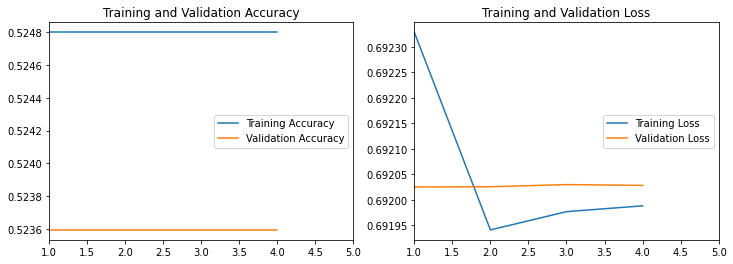

In [ ]:
#Presentation of accuracy and loss
show_acc_loss_chart(fwd_lstm_history)

In [ ]:
predicted_val = fwd_lstm_model.predict(X_test)

predicted_val[predicted_val <= 0.5] = int(0)
predicted_val[predicted_val > 0.5] = int(1)
predicted_lstm = predicted_val[:,0]

In [ ]:

print(classification_report(y_test, predicted_lstm,target_names = ['Not Sarcastic','Sarcastic']))



               precision    recall  f1-score   support

Not Sarcastic       0.52      1.00      0.69      2985
    Sarcastic       0.00      0.00      0.00      2716

     accuracy                           0.52      5701
    macro avg       0.26      0.50      0.34      5701
 weighted avg       0.27      0.52      0.36      5701



####Define and compile a Bidirectional LSTM model. 

In [ ]:
# Buildinhg a LSTM model

In [ ]:
biLSTM = Sequential()

biLSTM.add(Embedding(input_dim=num_words, output_dim=max_len, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False))
# biLSTM.add(Bidirectional(LSTM(units=128, recurrent_dropout = 0.3, dropout = 0.3, return_sequences = True)))
biLSTM.add(Bidirectional(LSTM(units=64, recurrent_dropout = 0.3, dropout = 0.3, return_sequences = True)))
biLSTM.add(Bidirectional(LSTM(units=32, recurrent_dropout = 0.1, dropout = 0.1)))
# biLSTM.add(Dense(16, activation='relu' ))
biLSTM.add(Dense(16, activation='tanh' ))
biLSTM.add(Dense(1, activation='sigmoid'))

biLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
biLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          2850200   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,976,953
Trainable params: 126,753
Non-

#####Fit the model and check the validation accuracy

In [ ]:
#Training
start = time.perf_counter()

early_stopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience=3)

biLSTM_history = biLSTM.fit(X_train, y_train, epochs=4, batch_size=1024, validation_data=(X_test, y_test),callbacks = [early_stopping])

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/4
23/23 [==============================] - 53s 2s/step - loss: 0.5719 - accuracy: 0.6964 - val_loss: 0.4868 - val_accuracy: 0.7620
Epoch 2/4
23/23 [==============================] - 39s 2s/step - loss: 0.4850 - accuracy: 0.7646 - val_loss: 0.4391 - val_accuracy: 0.7939
Epoch 3/4
23/23 [==============================] - 39s 2s/step - loss: 0.4249 - accuracy: 0.8024 - val_loss: 0.4043 - val_accuracy: 0.8074
Epoch 4/4
23/23 [==============================] - 39s 2s/step - loss: 0.3883 - accuracy: 0.8219 - val_loss: 0.3831 - val_accuracy: 0.8239
Elapsed 170.923 seconds.


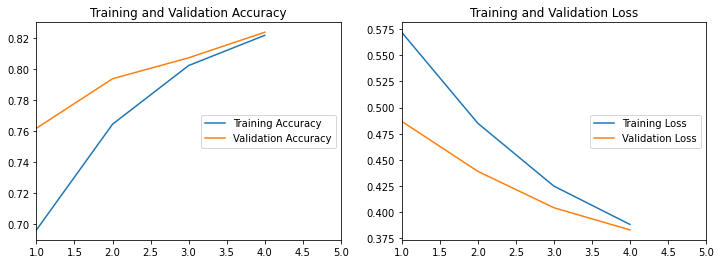

In [ ]:
#Presentation of accuracy and loss
show_acc_loss_chart(biLSTM_history)

In [ ]:
predicted_val = biLSTM.predict(X_test)
predicted_val[predicted_val <= 0.5] = int(0)
predicted_val[predicted_val > 0.5] = int(1)
predicted_biLSTM = predicted_val[:,0]

In [ ]:
print(classification_report(y_test, predicted_biLSTM,target_names = ['Not Sarcastic','Sarcastic']))


               precision    recall  f1-score   support

Not Sarcastic       0.81      0.88      0.84      2985
    Sarcastic       0.85      0.77      0.81      2716

     accuracy                           0.82      5701
    macro avg       0.83      0.82      0.82      5701
 weighted avg       0.83      0.82      0.82      5701



In [ ]:
real_val = y_test.tolist()

X_test_Orig_df = pd.DataFrame(X_test_Orig,columns=['headline'])
id_data = X_test_Orig_df.index.tolist()

id_wrong = np.where(real_val != predicted_biLSTM)[0]

In [ ]:
id_wrong.size

1004

In [ ]:
#Print a random new headline which was not correctly classified
id_random = id_wrong[random.randint(0,len(id_wrong))]
predicted_random = predicted_biLSTM[id_random]
real_random = real_val[id_random]

print("the news : ")
print(X_test_Orig_df.headline[(id_data[id_random])])
print()
print("Was predicted as {}".format(predicted_random))
print("but was {}".format(real_random))

the news : 
paul ryan removing devin nunes tax cuts working

Was predicted as 1.0
but was 0


Text(0.5, 15.0, 'True value')

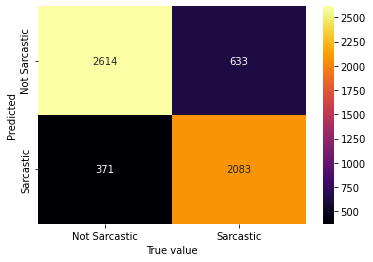

In [ ]:
#Present a confusion matrix

matrix = sklearn.metrics.confusion_matrix(predicted_val,real_val)
labels = ['Not Sarcastic','Sarcastic'] 
ax = sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap='inferno', annot=True, fmt="d")
ax.set_ylabel('Predicted')
ax.set_xlabel('True value')

####Building a BERT Transformer model for exploratory purpose

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 6.5 MB 33.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import TFBertModel, BertTokenizer

In [ ]:
labels = data_file.is_sarcastic.values
sentences = data_file.headline.values
data_file.head()

,headline,is_sarcastic,words
0,thirtysomething scientists unveil doomsday clo...,1,8
1,dem rep totally nails why congress is falling ...,0,13
2,eat your veggies 9 deliciously different recipes,0,7
3,inclement weather prevents liar from getting t...,1,8
4,mother comes pretty close to using word stream...,1,9


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#Train test split
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences,labels,test_size=0.15)

train_ids = encoder(train_sents)
test_ids = encoder(test_sents) 

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

In [ ]:
test_ids

<tf.Tensor: shape=(4276, 16), dtype=int32, numpy=
array([[  101,  6221,  8398, ...,     0,     0,     0],
       [  101,  2474,  6316, ...,  1037, 10156,   102],
       [  101,  3290, 17472, ...,     0,     0,     0],
       ...,
       [  101,  2403,  4174, ..., 10286,  1998,   102],
       [  101,  3533, 11019, ...,   102,     0,     0],
       [  101,  2047,  2732, ..., 11783,  9152,   102]], dtype=int32)>

In [ ]:
test_labels

<tf.Tensor: shape=(4276,), dtype=int64, numpy=array([0, 0, 1, ..., 0, 1, 1])>

In [ ]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

bert_model = tf.keras.Model(inputs=[input_word_ids], outputs=output) 

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
bert_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             16, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
bert_history = bert_model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/3
758/758 [==============================] - 108s 117ms/step - loss: 0.3389 - accuracy: 0.8519 - val_loss: 0.2404 - val_accuracy: 0.8952
Epoch 2/3
758/758 [==============================] - 87s 114ms/step - loss: 0.1915 - accuracy: 0.9224 - val_loss: 0.2285 - val_accuracy: 0.9121
Epoch 3/3
758/758 [==============================] - 84s 111ms/step - loss: 0.1130 - accuracy: 0.9584 - val_loss: 0.2507 - val_accuracy: 0.9203


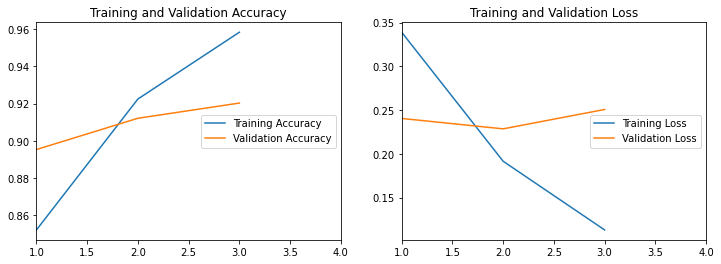

In [ ]:
#Presentation of accuracy and loss
show_acc_loss_chart(bert_history)

####Overall comparison of models for understanding the model performance

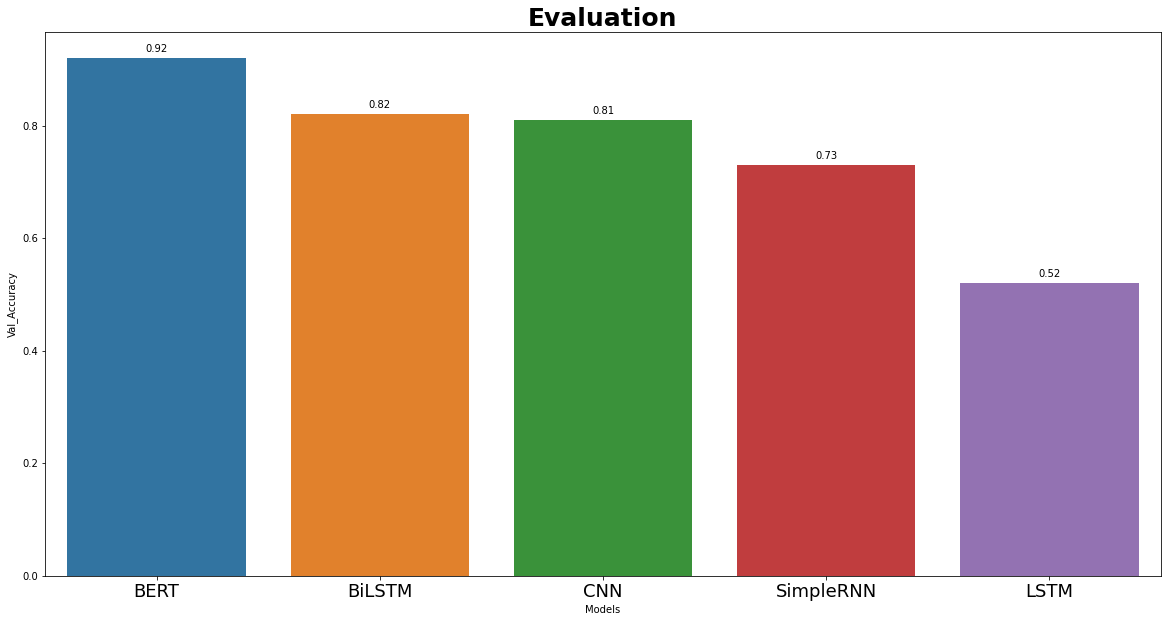

In [ ]:
accuracy_simple_rnn = accuracy_score(y_test, predicted_simpleRNN)
accuracy_CNN = np.max(CNN_history.history['val_accuracy'])
accuracy_lstm = accuracy_score(y_test,predicted_lstm)
accuracy_bi_lstm = accuracy_score(y_test, predicted_biLSTM)
accuracy_bi_BERT = np.max(bert_history.history['val_accuracy'])

conclusion = pd.DataFrame({'Models':['SimpleRNN', 'CNN', 'LSTM', 'BiLSTM','BERT'], 
              'Accuracy':[accuracy_simple_rnn, accuracy_CNN, accuracy_lstm, accuracy_bi_lstm,accuracy_bi_BERT]})
conclusion['Accuracy'] = conclusion['Accuracy'].apply(lambda x: round(x,2))
conclusion.sort_values(by='Accuracy', inplace = True, ascending = False)

plt.figure(figsize=(20,10))
seaborn_plot = sns.barplot(conclusion.Models,conclusion.Accuracy)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Evaluation", weight='bold', size=25)
plt.xticks(size=18)
plt.xlabel("Models")
plt.ylabel("Val_Accuracy")
plt.show()

Overall time taken is roughly 12-13 mins for all the model comparison

In [ ]:
overall_elapsed = time.perf_counter() - start_of_run
print('Elapsed %.3f seconds.' % overall_elapsed)

Elapsed 768.453 seconds.


###Conclusion and Learning:

Conclusion: After running with different models, it is very clear that Bi directional LSTM has better performance against other models leaving the BERT model
BERT model is standing out because it is a pre-trained model with better vocab corpus and stronger network to predict the words and its sequence
SimpeRNN and simple LSTM are not the models to go for word sequence and its associated charateristics
as given here, CNN training and testing score on the given dataset is good, but it may not the case in real-life texts.
